In [ ]:
import pywt #先安装，如果你没有的话 pip install PyWavelets
import numpy as np

导入数据集，较大文件可能耗时较长。

In [9]:
file = np.load("CWRU_48k_load_1_CNN_data.npz")
print(file.files)

['data', 'labels']


In [10]:
data = file["data"]
labels = file["labels"]
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [11]:
resized_data = np.reshape(data, (2300,2048))
resized_data.shape

(2300, 2048)

小波包分解

In [12]:
wp = pywt.WaveletPacket(resized_data[0,:], wavelet = "sym8", maxlevel = 3) # Computes 3 level wavelet packet decomposition

In [13]:
packet_names = [node.path for node in wp.get_level(3, "natural")]  # Packet node names. 
packet_names  # The naming of nodes as "aaa", "aad" is conventional in wavelets. "a" means approximation. "d" means details.

['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']

In [14]:
[wp[node.path].data.shape for node in wp.get_level(3, "natural")] # Number of coefficients after 3 stage transformation.

[(269,), (269,), (269,), (269,), (269,), (269,), (269,), (269,)]

能量

In [15]:
feature_matrix_wav_packet_energy = np.repeat(np.nan, 2300*8).reshape(2300,8)
for i in range(len(resized_data)):
    wp = pywt.WaveletPacket(resized_data[i,:], wavelet = "sym8", maxlevel = 3) # Wavelet packet transformation
    for j in range(8):
        new_wp = pywt.WaveletPacket(data = None, wavelet = "sym8", maxlevel = 3)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        feature_matrix_wav_packet_energy[i,j] = np.linalg.norm(reconstructed_signal)**2 # Energy of reconstructed signal for every node

SVM

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
categories = ["Ball_007_1", "Ball_014_1", "Ball_021_1", "IR_007_1", "IR_014_1", "IR_021_1",
              "OR_007_6_1", "OR_014_6_1", "OR_021_6_1", "Normal_1"]

In [18]:
# We are overwriting old labels as we need only 2300 labels.
labels = pd.Categorical(np.repeat(categories, repeats = 230), categories = categories)

数据集划分

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(feature_matrix_wav_packet_energy, labels,
                                                                    test_size = 750, stratify = labels,
                                                                    random_state = 123)
test_labels.value_counts()

Ball_007_1    75
Ball_014_1    75
Ball_021_1    75
IR_007_1      75
IR_014_1      75
IR_021_1      75
OR_007_6_1    75
OR_014_6_1    75
OR_021_6_1    75
Normal_1      75
Name: count, dtype: int64

分类模型一般需要标准化数据。

In [20]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

网格寻参

In [21]:
parameters = {"C":[1, 10, 50, 100, 500, 1000, 5000],
             'gamma':[0.05, 0.1, 0.5, 1, 5],
             'kernel':["rbf"]}

In [22]:
tuned_svm_clf = GridSearchCV(SVC(),parameters,n_jobs = -1, cv= 10)

In [23]:
tuned_svm_clf.fit(train_data_scaled, train_labels)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 500, 1000, 5000],
                         'gamma': [0.05, 0.1, 0.5, 1, 5], 'kernel': ['rbf']})

In [24]:
tuned_svm_clf.best_score_

0.9806451612903226

In [25]:
tuned_svm_clf.best_params_

{'C': 5000, 'gamma': 0.5, 'kernel': 'rbf'}

In [26]:
best_clf = tuned_svm_clf.best_estimator_
best_clf

SVC(C=5000, gamma=0.5)

In [27]:
train_predictions = best_clf.predict(train_data_scaled)
test_predictions = best_clf.predict(test_data_scaled)

In [28]:
train_confu_matrix = confusion_matrix(train_labels, train_predictions)
test_confu_matrix = confusion_matrix(test_labels, test_predictions)

训练集混淆矩阵

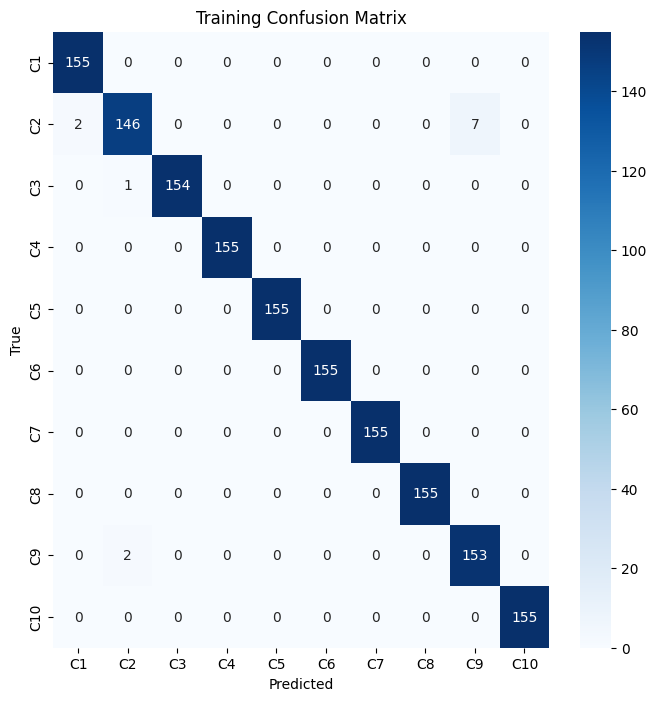

In [32]:
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(1,figsize=(8,8))
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

测试集

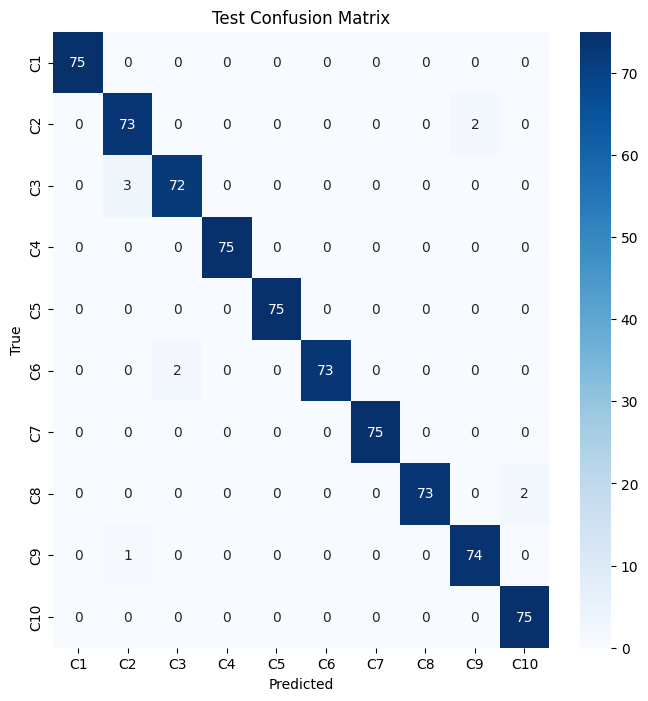

In [33]:
plt.figure(figsize=(8,8))
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
overall_test_accuracy = accuracy_score(test_labels, test_predictions)
print("综合准确率: ", overall_test_accuracy)

综合准确率:  0.9866666666666667
